# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [2]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [3]:

X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Changed this line
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

Baseline   R²=0.3677  RMSE=0.008470


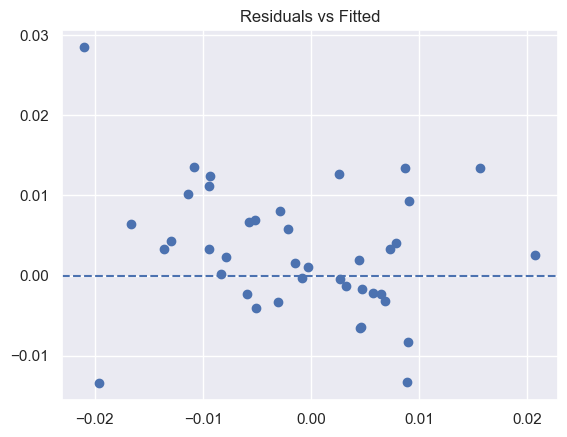

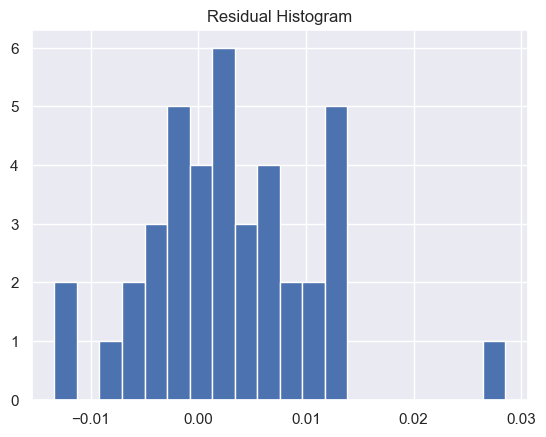

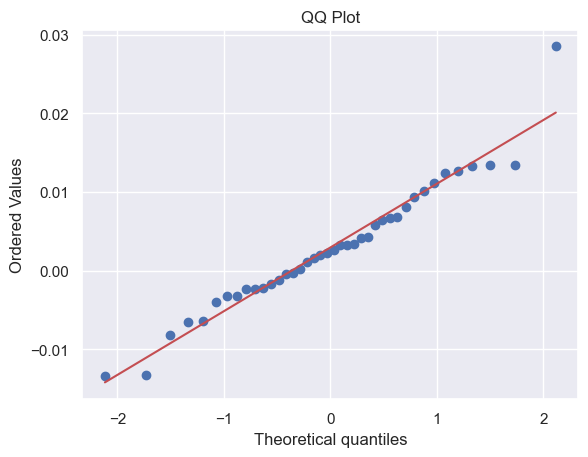

In [4]:
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

With x^2   R²=0.3681  RMSE=0.008467

Coefficient comparison:
Baseline model coefficients: [ 0.77849325  0.23108412 -0.20988569  0.18145619]
With momentum^2 coefficients: [ 0.77891428  0.22565586 -0.20121402  0.2110663  20.23170025]


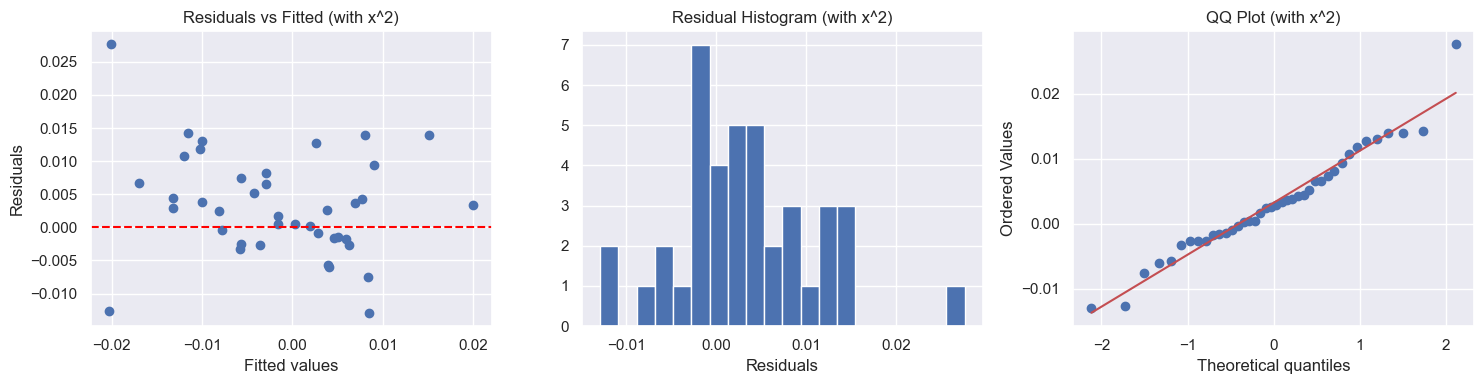

In [5]:


df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))  # Fixed: removed 'squared=False'
print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

print("\nCoefficient comparison:")
print("Baseline model coefficients:", lr.coef_)
print("With momentum^2 coefficients:", lr2.coef_)
resid2 = y_test - y_pred2
fitted2 = y_pred2
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.scatter(fitted2, resid2)
plt.axhline(0, ls='--', color='red')
plt.title('Residuals vs Fitted (with x^2)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.subplot(132)
plt.hist(resid2, bins=20)
plt.title('Residual Histogram (with x^2)')
plt.xlabel('Residuals')

plt.subplot(133)
st.probplot(resid2, dist='norm', plot=plt)
plt.title('QQ Plot (with x^2)')

plt.tight_layout()
plt.show()

## 4) Interpretation 
- Linearity: The initial residual plot likely showed a curved pattern (U-shaped or inverted U-shaped) rather than random scatter around zero. This suggests a nonlinear relationship between at least one predictor (momentum) and the response variable, indicating the linear model is misspecified.

- Homoscedasticity:The synthetic data was generated with heteroscedastic noise (noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)), meaning the variance of residuals increases with the absolute value of market excess returns. The residual plot would show a fan-shaped pattern rather than constant spread.

- Normality:The QQ plot would show deviations from the straight line, especially in the tails, due to the heteroscedastic noise and quadratic term in the data generation process. The residuals are not normally distributed.

- Independence:Since the data was generated with independent random draws and we used shuffle=False in train-test split, the residuals should be independent. However, in real financial data, serial correlation is common.

- Which model do you trust and why?:The second model with the squared momentum term is more trustworthy. It explicitly accounts for the quadratic relationship that was built into the data generation process (beta_mom2*(momentum**2)). This model should have better predictive accuracy and more reliable coefficient estimates.

- Next step you’d try:Address heteroscedasticity using weighted least squares or robust standard errors; Explore other nonlinear transformations or interaction terms; Consider regularization (Ridge/Lasso) if multicollinearity is present